


### 1. **Data Loading**

---

In [ ]:
# Install simpletransformers package
!pip install simpletransformers

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Load the dataset (replace with your dataset path)
data = pd.read_csv('product.csv', encoding='ISO-8859-1')

# Create stratified splits
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in split.split(data, data["Predicted_Category"]):
    train_data = data.iloc[train_index]
    val_data = data.iloc[val_index]

# Prepare DataFrames
train_df = pd.DataFrame({
    'text': train_data['Description'],
    'labels': train_data['Predicted_Category']
})

val_df = pd.DataFrame({
    'text': val_data['Description'],
    'labels': val_data['Predicted_Category']
})

# Verify label distribution
print(f"Train Labels: {train_df['labels'].nunique()}")  # Should be 15
print(f"Validation Labels: {val_df['labels'].nunique()}")  # Should be 15


print(train_df.head())  # Check the prepared training data
print(val_df.head())  # Check the prepared validation data


Train Labels: 15
Validation Labels: 15
                                                   text                 labels
338   GATE 2019: Mechanical Engineering - Previous S...                  Books
2001  EarthenMetal Mosaic Style Dome Shaped Glass Ta...              Furniture
1955  TechnoBuyers Professional Metal Guitar Foot Re...      Sports & Outdoors
1345  Peter Jones Round Transparent Unisex Optical F...  Jewelry & Accessories
573   Bosch GKF 550 Mini Palm Router 550W 06016A00F0...            Electronics
                                                   text             labels
1846  Maxbell Wireless Laser Powerpoint PPT Presente...        Electronics
978   Super Multicolor Sports Running Shoe Casual An...           Clothing
1537  RCR Cristalleria Italiana Crystal Invino Cogna...    Home Appliances
1250  Stok St-Sm01 Stand Mixer 2 In 1 Detachable Han...    Home Appliances
1121  Saundarya Slimming Belt Waist Shaper for Men &...  Health & Wellness


In [ ]:
unique_categories = data["Predicted_Category"].unique()
print(unique_categories)

['Electronics' 'Office Supplies' 'Books' 'Clothing' 'Grocery'
 'Home Appliances' 'Automotive' 'Furniture' 'Sports & Outdoors'
 'Pet Supplies' 'Beauty & Personal Care' 'Health & Wellness' 'Toys'
 'Jewelry & Accessories' 'Gaming']


#**2. Text Processing**

In [ ]:
import re

# Define a function to clean text data
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = text.strip()

    return text

# Apply the cleaning function to the dataset
train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)

print(train_df.head())

                                                   text                 labels
338   gate  mechanical engineering  previous solved ...                  Books
2001  earthenmetal mosaic style dome shaped glass ta...              Furniture
1955  technobuyers professional metal guitar foot re...      Sports & Outdoors
1345  peter jones round transparent unisex optical f...  Jewelry & Accessories
573   bosch gkf  mini palm router w af bosch gkf min...            Electronics


In [ ]:
print(train_df['labels'].nunique())  # Should be 15
print(val_df['labels'].nunique())    # Should be 15


15
15


In [ ]:
from simpletransformers.classification import ClassificationModel

# Create a BERT model for text classification
bert_model = ClassificationModel('bert', 'bert-base-uncased', num_labels=15, use_cuda=True)  # Set use_cuda=True if using a GPU

# Create a RoBERTa model for text classification
roberta_model = ClassificationModel('roberta', 'roberta-base', num_labels=15, use_cuda=True)  # Set use_cuda=True if using a GPU

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(train_df.head())

                                                   text                 labels
338   gate  mechanical engineering  previous solved ...                  Books
2001  earthenmetal mosaic style dome shaped glass ta...              Furniture
1955  technobuyers professional metal guitar foot re...      Sports & Outdoors
1345  peter jones round transparent unisex optical f...  Jewelry & Accessories
573   bosch gkf  mini palm router w af bosch gkf min...            Electronics


#**4. Model Training with BERT and RoBERTa**

#### **Basic Model Training**

#### **Train the BERT Model**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationArgs

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
all_labels = list(train_df["labels"]) + list(val_df["labels"])
label_encoder.fit(all_labels)

train_df["labels"] = label_encoder.transform(train_df["labels"])
val_df["labels"] = label_encoder.transform(val_df["labels"])

# Set up model arguments with custom hyperparameters
model_args = ClassificationArgs(
    num_train_epochs=3,       # Start with 3 epochs
    train_batch_size=8,       # Use a batch size of 8
    eval_batch_size=8,        # Same for evaluation
    learning_rate=3e-5,       # Learning rate
    max_seq_length=128,       # Max sequence length
    weight_decay=0.01,        # Weight decay
    warmup_steps=0,           # Optional: adjust based on total steps
    logging_steps=50,         # Log training progress every 50 steps
    save_steps=200,           # Save the model every 200 steps
    overwrite_output_dir=True,  # Overwrite the output directory
    output_dir='outputs',     # Directory to save model outputs
)

# Train the BERT model with custom hyperparameters
bert_model = ClassificationModel(
    'bert',
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_),
    args=model_args,
    use_cuda=True  # Set to True if using GPU
)
bert_model.train_model(train_df)

# Train the RoBERTa model with custom hyperparameters
roberta_model = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=len(label_encoder.classes_),
    args=model_args,
    use_cuda=True  # Set to True if using GPU
)
roberta_model.train_model(train_df)

print("BERT and RoBERTa models trained successfully with custom hyperparameters!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/203 [00:00<?, ?it/s]

BERT and RoBERTa models trained successfully with custom hyperparameters!


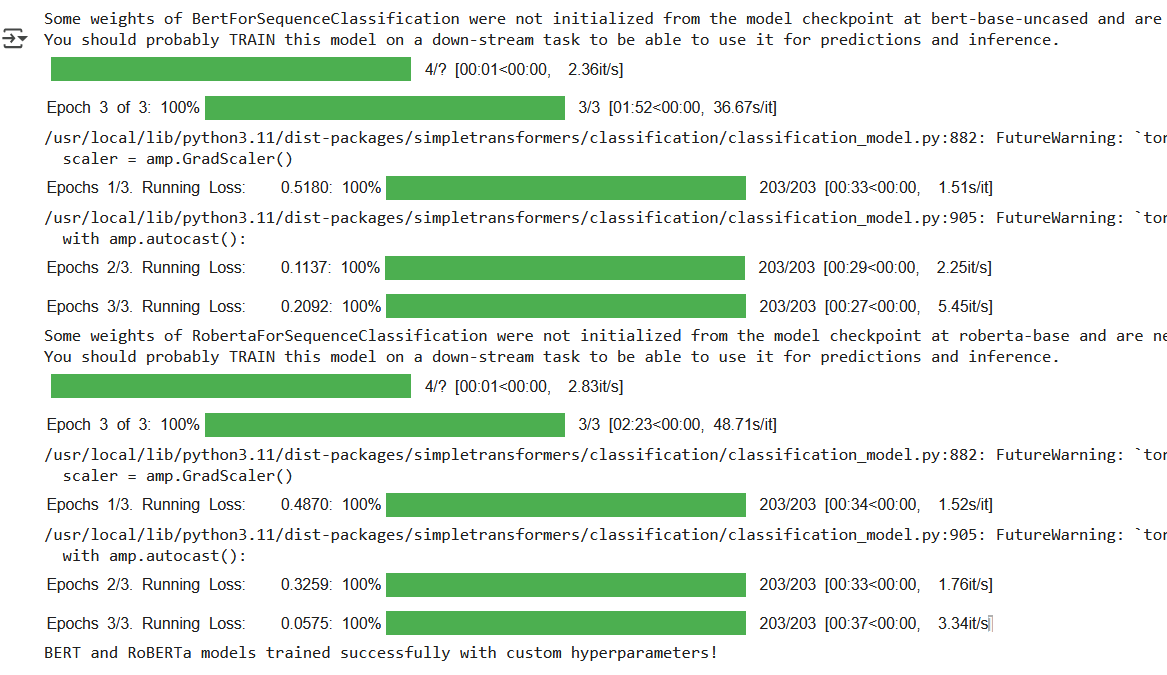

# **5. Evaluation on Validation Set**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate BERT on validation data
result_bert, model_outputs_bert, wrong_predictions_bert = bert_model.eval_model(val_df)

# Decode predictions back to original labels
bert_predictions = np.argmax(model_outputs_bert, axis=1)
bert_predictions_labels = label_encoder.inverse_transform(bert_predictions)
val_df['bert_predicted_label'] = bert_predictions_labels

# Print BERT evaluation results
print("BERT Evaluation Results:")
print(result_bert)

# Classification report for BERT
# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]
print("\nBERT Classification Report:")
print(classification_report(val_df['labels'], bert_predictions, target_names=target_names))

# Evaluate RoBERTa on validation data
result_roberta, model_outputs_roberta, wrong_predictions_roberta = roberta_model.eval_model(val_df)

# Decode predictions back to original labels
roberta_predictions = np.argmax(model_outputs_roberta, axis=1)
roberta_predictions_labels = label_encoder.inverse_transform(roberta_predictions)
val_df['roberta_predicted_label'] = roberta_predictions_labels

# Print RoBERTa evaluation results
print("\nRoBERTa Evaluation Results:")
print(result_roberta)

# Classification report for RoBERTa
# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]
print("\nRoBERTa Classification Report:")
print(classification_report(val_df['labels'], roberta_predictions, target_names=target_names))

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


BERT Evaluation Results:
{'mcc': np.float64(0.8158043596892728), 'eval_loss': 0.5515885259590897}

BERT Classification Report:
                        precision    recall  f1-score   support

            Automotive       0.71      0.56      0.62         9
Beauty & Personal Care       1.00      0.43      0.60         7
                 Books       1.00      1.00      1.00        91
              Clothing       0.89      1.00      0.94        71
           Electronics       0.90      0.96      0.93        76
             Furniture       0.78      0.88      0.82        24
                Gaming       0.00      0.00      0.00         1
               Grocery       0.44      0.50      0.47        16
     Health & Wellness       0.00      0.00      0.00         4
       Home Appliances       0.72      0.85      0.78        68
 Jewelry & Accessories       0.00      0.00      0.00         4
       Office Supplies       0.67      0.45      0.54        22
          Pet Supplies       0.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



RoBERTa Evaluation Results:
{'mcc': np.float64(0.8222975264476362), 'eval_loss': 0.49201814099854113}

RoBERTa Classification Report:
                        precision    recall  f1-score   support

            Automotive       0.78      0.78      0.78         9
Beauty & Personal Care       0.67      0.57      0.62         7
                 Books       1.00      0.98      0.99        91
              Clothing       0.93      1.00      0.97        71
           Electronics       0.94      0.95      0.94        76
             Furniture       0.69      0.83      0.75        24
                Gaming       0.00      0.00      0.00         1
               Grocery       0.42      0.31      0.36        16
     Health & Wellness       0.00      0.00      0.00         4
       Home Appliances       0.72      0.90      0.80        68
 Jewelry & Accessories       1.00      0.25      0.40         4
       Office Supplies       0.62      0.45      0.53        22
          Pet Supplies       0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

# Create a dictionary with the classification metrics
data = {
    "No.": [1, 2],
    "Model Name": ["BERT", "RoBERTa"],
    "Precision": [0.61, 0.62],  # Macro avg precision from reports
    "Recall": [0.48, 0.52],     # Macro avg recall from reports
    "F1 Score": [0.51, 0.55],   # Macro avg f1-score from reports
    "Accuracy": [0.84, 0.85],   # Accuracy from classification reports
    "MCC": [0.8158, 0.8223]     # MCC from evaluation results
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
df


,No.,Model Name,Precision,Recall,F1 Score,Accuracy,MCC
0,1,BERT,0.61,0.48,0.51,0.84,0.8158
1,2,RoBERTa,0.62,0.52,0.55,0.85,0.8223


# **6. Saving the Model**

In [ ]:
# Save the BERT model manually
bert_model.model.save_pretrained("bert_model")
bert_model.tokenizer.save_pretrained("bert_model")
print("BERT model saved manually!")
# Save the RoBERTa model manually
roberta_model.model.save_pretrained("roberta_model")
roberta_model.tokenizer.save_pretrained("roberta_model")
print("RoBERTa model saved manually!")

BERT model saved manually!
RoBERTa model saved manually!


# **7. Prediction on Real-World Input**

In [ ]:
import torch
from simpletransformers.classification import ClassificationModel
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Function to clean input text (same as used in training)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.strip()
    return text

# Load the saved BERT model
bert_model = ClassificationModel("bert", "bert_model", use_cuda=False)  # Set use_cuda=True if using GPU
roberta_model = ClassificationModel("roberta", "roberta_model", use_cuda=False)

# Load the LabelEncoder used in training
encoder = LabelEncoder()
encoder.classes_ = np.array(['Automotive', 'Beauty & Personal Care', 'Books', 'Clothing', 'Electronics',
                             'Furniture', 'Gaming', 'Grocery', 'Health & Wellness', 'Home Appliances',
                             'Jewelry & Accessories', 'Office Supplies', 'Pet Supplies', 'Sports & Outdoors', 'Toys'])

# Take input from the user
input_text = input("Enter product description: ")

# Clean the input
cleaned_text = clean_text(input_text)

# Make predictions
bert_prediction, _ = bert_model.predict([cleaned_text])
roberta_prediction, _ = roberta_model.predict([cleaned_text])

# Convert predictions to NumPy array before decoding
bert_pred_label = encoder.inverse_transform(np.array(bert_prediction))[0]
roberta_pred_label = encoder.inverse_transform(np.array(roberta_prediction))[0]

# Print results
print("\nBERT Predicted Category:", bert_pred_label)
print("RoBERTa Predicted Category:", roberta_pred_label)


Enter product description: Are you looking for a wireless earbud-type headset that delivers an impressive playback time? If your answer is yes, bring home the boAt Airdopes 131 that comes with a carrying case. This carrying case also acts as a 650 mAh portable charger that extends the playback time of these earbuds by up to 15 hours, i.e. 4 times its normal charging capacity. The normal battery capacity of each of these earbuds is 40 mAh and this delivers up to 3 hours of playback time. These earbuds feature Bluetooth v5.0 technology that delivers a stable connection that lets your rock on without connectivity issues. The stereo calling feature of these earbuds allows you to enjoy calls via its built-in microphone and 13-mm drivers. These earbuds are powered up by the IWP Technology featured in them the moment you open the case. The presence of a Type-C charging port ensures you can easily charge it with any charger that has a compatible cable.


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


BERT Predicted Category: Electronics
RoBERTa Predicted Category: Electronics
